# BO with `ax_platform=0.4.3`

install with `pip install ax-platform==0.4.3`

https://ax.dev/

## Outline
This notebook demonstrates the use of Bayesian Optimization to find the optimal parameters for a synthetic Gaussian objective function. The key steps involved are:

1. **Define Optimization Parameters**: Set up the parameter names, bounds, and the objective function.
2. **Initialize Bayesian Optimizer**: Configure the Bayesian Optimizer Iterator with the defined parameters and settings.
3. **Run Optimization Loop**: Execute the optimization loop to iteratively suggest new parameters and observe the objective values.
4. **Store Results**: Collect the suggested parameters and observed objective values, and identify the best result.
5. **Visualize Results**: Plot the true objective function, interpolated surface, and model predictions to visualize the optimization process and results.

# Setup and Run BO

In [1]:
from BO_Iterator import BayesianOptimizerIterator, SyntheticGaussian

# Define the optimization parameters
param_names    = ["a", "b"]                  # Names of the parameters to optimize
param_bounds   = [[-1.0, 1.0], [-1.0, 1.0]]  # Bounds for each parameter
centers        = [0.2, 0.1]                  # Center of the synthetic Gaussian function (target optimum)
sigma          = 0.1                         # Standard deviation of the Gaussian function

# This synthetic function simulates a noisy Gaussian-like optimization problem
objective_function = SyntheticGaussian(centers=centers, sigma=sigma, n_samples=1).read

# Define Bayesian Optimization settings
num_sobol   = 20                             # Number of initial Sobol samples (random exploration phase)
num_gpei    = 30                             # Number of GPEI trials (Gaussian Process phase for exploitation)
batch_size  = 2                              # Number of trials to evaluate in parallel during GPEI phase
threshold   = 0.999                          # Threshold value for early stopping (objective goal)
epsilon     = 0.001                          # Minimum improvement to reset patience in GPEI phase
patience    = 20                             # Number of consecutive GPEI steps allowed without improvement
maximize    = True                           # Whether to maximize (True) or minimize (False) the objective

# Initialize the Bayesian Optimizer Iterator
bo_iterator = BayesianOptimizerIterator(
    objective_function = objective_function, # The objective function to optimize
    param_names        = param_names,        # Names of the parameters
    param_bounds       = param_bounds,       # Bounds for the parameters
    num_sobol          = num_sobol,          # Number of initial Sobol samples
    num_gpei           = num_gpei,           # Number of GPEI trials
    batch_size         = batch_size,         # Number of parallel evaluations
    threshold          = threshold,          # Stopping threshold based on the objective
    epsilon            = epsilon,            # Convergence tolerance for improvement
    patience           = patience,           # Maximum steps allowed without improvement
    maximize           = maximize,           # Whether to maximize or minimize the objective
)

# Run the optimization loop
for params in bo_iterator:
    pass

# Retrieve the final best parameters and value from the iterator
all_obs     = bo_iterator.get_all_observations()  
final_model = bo_iterator.get_final_model()

[INFO 12-31 22:48:52] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-31 22:48:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-31 22:48:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-31 22:48:52] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='a', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='b', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 12-31 22:48:52] a

Stopping early: Threshold exceeded.


# Printing the Best Result

In [2]:
# real peak @ 1 = (0.2, 0.1)
all_obs['best_result']

{'params': {'a': 0.20092592378470187, 'b': 0.09648586921087987},
 'objectives': 0.9993398954620196}

# Visualizing of the Result

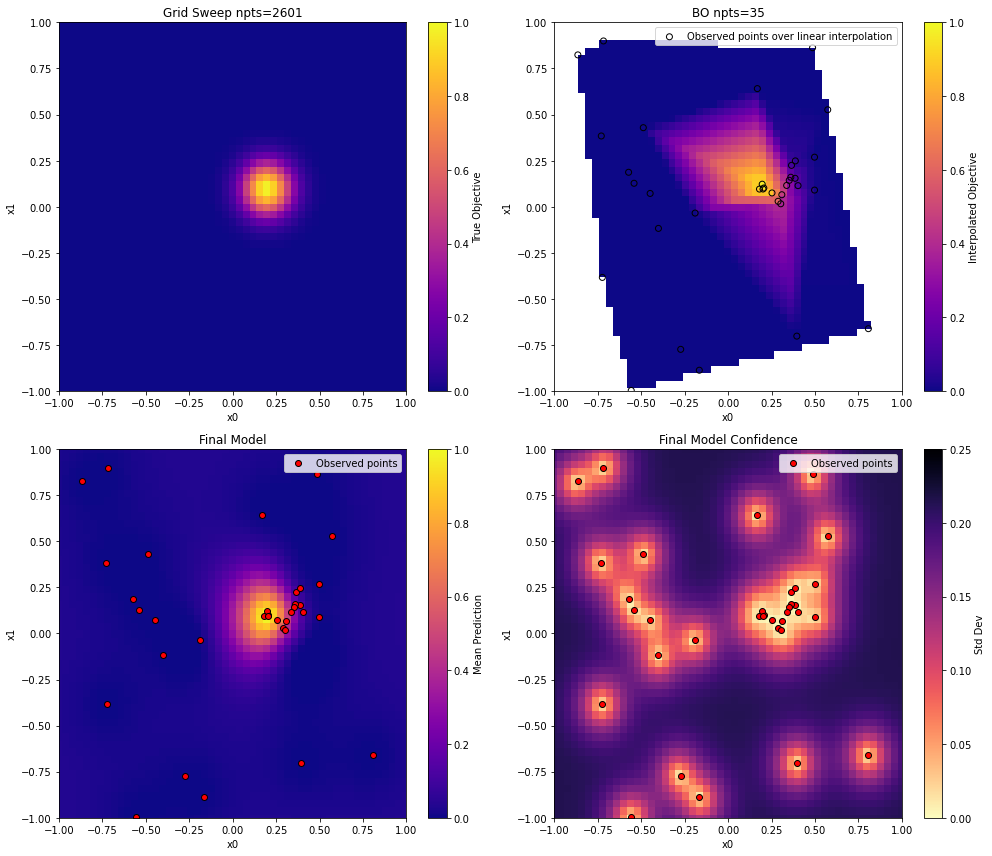

In [3]:
import numpy as np
from ax.core.observation import ObservationFeatures
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# --- Extract observed x0, x1, and objective means ---
# (We take only the first element of each (mean, sem) tuple)
x0_vals = [p[param_names[0]] for p in all_obs["params"]]
x1_vals = [p[param_names[1]] for p in all_obs["params"]]
obj_means = [obj_tuple[0] for obj_tuple in all_obs["objectives"]]

# --- Grid Sweep: True Objective Function ---
x0 = np.linspace(-1, 1, 51)
x1 = np.linspace(-1, 1, 51)
x0_grid, x1_grid = np.meshgrid(x0, x1)
objective_grid = np.exp(
    -((x0_grid - centers[0]) ** 2 + (x1_grid - centers[1]) ** 2) / (2 * sigma**2)
)

# --- Interpolated Surface from Observations ---
x0_interp_grid, x1_interp_grid = np.meshgrid(x0, x1)
objective_interp = griddata(
    (x0_vals, x1_vals),
    obj_means,
    (x0_interp_grid, x1_interp_grid),
    method="linear"
)

# --- Model Predictions (Mean and Std Dev) ---
# Prepare grid for evaluation
mesh = np.column_stack([x0_grid.ravel(), x1_grid.ravel()])

# Convert grid points to Ax-compatible observation features
observation_features = [
    ObservationFeatures(parameters={
        param_names[0]: float(x0_val),
        param_names[1]: float(x1_val)
    })
    for x0_val, x1_val in mesh
]

# Predict using the final model
mean_dict, cov_dict = final_model.predict(observation_features)

# Extract mean and covariance
mean_objective = np.array(mean_dict["objective"])
cov_objective = np.array(cov_dict["objective"]["objective"])

# Compute variance and standard deviation
var = cov_objective if cov_objective.ndim == 1 else np.diag(cov_objective)
std = np.sqrt(var)

# Reshape predictions to the grid
f_mean_grid = mean_objective.reshape(x0_grid.shape)
f_std_grid  = std.reshape(x0_grid.shape)

# --- Plot Results in a 2x2 Grid ---
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Titles and labels
titles = ["Grid Sweep npts=2601", f"BO npts={len(x0_vals)}", "Final Model", "Final Model Confidence"]

cbar_labels = ["True Objective", "Interpolated Objective", "Mean Prediction", "Std Dev"]
plot_labels = [None, "Observed points over linear interpolation", "Observed points", "Observed points"]
data   = [objective_grid, objective_interp, f_mean_grid, f_std_grid]
cmaps  = ["plasma", "plasma", "plasma", "magma_r"]
vmins  = [0, 0, 0, 0]
vmaxs  = [1, 1, 1, 0.25]
scatter_colors = ["none", "none", "red", "red"]

for i, ax_i in enumerate(ax.flat):
    c = ax_i.pcolormesh(x0_grid, x1_grid, data[i],
                        shading="auto", cmap=cmaps[i],
                        vmin=vmins[i], vmax=vmaxs[i])
    if i > 0:
        ax_i.scatter(
            x0_vals, x1_vals,
            edgecolor="black",
            facecolor=scatter_colors[i],
            label=plot_labels[i]
        )
        ax_i.legend(loc="upper right")

    ax_i.set_title(titles[i])
    ax_i.set_xlabel("x0")
    ax_i.set_ylabel("x1")
    ax_i.set_xlim(-1, 1)
    ax_i.set_ylim(-1, 1)
    fig.colorbar(c, ax=ax_i, label=cbar_labels[i])

plt.tight_layout()
plt.show()


# Plotting convergence

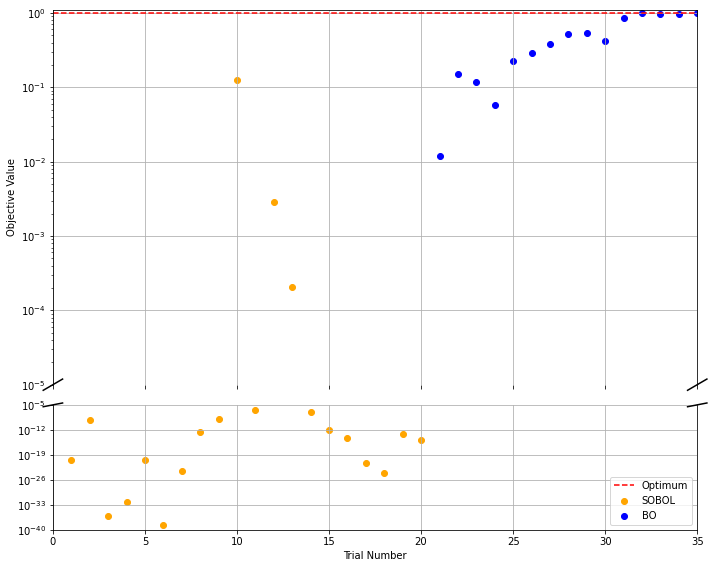

In [4]:
# Extract the primary objective (the first element of each (mean, sem) tuple)
objectives_list = [obj_tuple[0] for obj_tuple in all_obs["objectives"]]

# Data preparation
num_initial_samples = num_sobol  # the same value passed to BayesianOptimizerIterator
trial_numbers = list(range(1, len(objectives_list) + 1))

# Split the data into the initial Sobol phase (random) and subsequent BO phase
random_trials = trial_numbers[:num_initial_samples]
random_objectives = objectives_list[:num_initial_samples]
bo_trials = trial_numbers[num_initial_samples:]
bo_objectives = objectives_list[num_initial_samples:]

# Create the figure and two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8),
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# Plot data
for ax in [ax1, ax2]:
    ax.scatter(random_trials, random_objectives, color='orange', label="SOBOL")
    ax.scatter(bo_trials, bo_objectives, marker='o', linestyle='-', color='b', label="BO")
    ax.axhline(y=1, color='r', linestyle='--', label="Optimum")
    ax.grid(True)
    if ax == ax2:
        ax.legend(loc="lower right")

# Set y-axis limits and scales
ax1.set_ylim(1e-5, 1.1e0)
ax2.set_ylim(1e-40, 1e-5)
ax1.set_yscale("log")
ax2.set_yscale("log")

# Hide the spines between the two y-axes
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)
ax2.tick_params(labeltop=False)

# Add diagonal lines to indicate the split
d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Set labels and limits
ax2.set_xlabel("Trial Number")
ax1.set_ylabel("Objective Value")
ax1.set_xlim(0, len(trial_numbers))

plt.tight_layout()
plt.show()
